# Sistemas de Big Data - Apartado 3

Trabajaremos con el dataset de pingüinos del archipiélago Palmer, que se puede descargar desde Kaggle (archivo penguins_size.csv), con el cual ya hemos trabajado en el módulo de Programación de IA. También puedes descargar el archivo desde:
https://raw.githubusercontent.com/tnavarrete-iedib/bigdata-24-25/refs/heads/main/penguins_size.csv.

Este dataset tiene 6 columnas de entrada, en este orden:
- island: nombre de la isla (Dream, Torgersen o Biscoe)
- culmen_length_mm: longitud del pico en mm
- culmen_depth_mm: profundidad del pico en mm
- flipper_length_mm: longitud de la aleta en mm
- body_mass_g: masa corporal en gramos
- sex: sexo (MALE o FEMALE)

**IMPORTANTE**

Ten en cuenta que en los datos hay valores ausentes, etiquetados como NA. Debes eliminar toda la fila si tiene un NA en cualquiera de sus columnas.

Además, hay dos columnas con valores no numéricos, por lo que necesitarás hacer una conversión para poder trabajar con modelos de aprendizaje automático.

⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻⸻

También hay una columna species que contiene la etiqueta de la clase correspondiente, que puede ser una de estas tres especies de pingüino:
- Chinstrap
- Adélie
- Gentoo


Nos piden hacer un clustering de los datos del pico (longitud y profundidad) utilizando el algoritmo K-means con k=3.
Debes obtener los 3 centroides y representar gráficamente los 3 clústeres obtenidos con colores diferentes. También debes calcular el coeficiente Silhouette para evaluar la calidad del clustering. Comenta los resultados obtenidos.

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
import seaborn as sns
import numpy as np
import pandas as pd

spark = SparkSession.builder \
    .appName("Penguins_clustering") \
    .getOrCreate()

url = "https://raw.githubusercontent.com/tnavarrete-iedib/bigdata-24-25/refs/heads/main/penguins_size.csv"

!wget -q $url -O penguins_size.csv

penguins_df = spark.read.csv("penguins_size.csv", header=True, inferSchema=True)
penguins_df.show(5)

+-------+---------+----------------+---------------+-----------------+-----------+------+
|species|   island|culmen_length_mm|culmen_depth_mm|flipper_length_mm|body_mass_g|   sex|
+-------+---------+----------------+---------------+-----------------+-----------+------+
| Adelie|Torgersen|            39.1|           18.7|              181|       3750|  MALE|
| Adelie|Torgersen|            39.5|           17.4|              186|       3800|FEMALE|
| Adelie|Torgersen|            40.3|             18|              195|       3250|FEMALE|
| Adelie|Torgersen|              NA|             NA|               NA|         NA|    NA|
| Adelie|Torgersen|            36.7|           19.3|              193|       3450|FEMALE|
+-------+---------+----------------+---------------+-----------------+-----------+------+
only showing top 5 rows



In [3]:
penguins_clean = penguins_df.na.drop()
penguins_clean = penguins_clean.withColumn("culmen_length_mm", penguins_clean["culmen_length_mm"].cast(DoubleType()))
penguins_clean = penguins_clean.withColumn("culmen_depth_mm", penguins_clean["culmen_depth_mm"].cast(DoubleType()))

indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index")
    for col in ["island", "sex"]
]

encoders = [
    OneHotEncoder(inputCol=f"{col}_index", outputCol=f"{col}_vec")
    for col in ["island", "sex"]
]

# Guardamos el índice
species_indexer = StringIndexer(inputCol="species", outputCol="species_index")

assembler = VectorAssembler(
    inputCols=["culmen_length_mm", "culmen_depth_mm"],
    outputCol="features",
    handleInvalid="skip"
)

In [5]:
# Transformaciones aplicadas
pipeline = Pipeline(stages=indexers + encoders + [species_indexer, assembler])
transformed_df = pipeline.fit(penguins_clean).transform(penguins_clean)

kmeans = KMeans(featuresCol="features", k=3, seed=42)
model = kmeans.fit(transformed_df)
predictions = model.transform(transformed_df)

print("\nResultados del clustering después de las predicciones del modelo:")
predictions.select("features", "prediction", "species").show(7)


Resultados del clustering después de las predicciones del modelo:
+-----------+----------+-------+
|   features|prediction|species|
+-----------+----------+-------+
|[39.1,18.7]|         1| Adelie|
|[39.5,17.4]|         1| Adelie|
|[40.3,18.0]|         1| Adelie|
|[36.7,19.3]|         1| Adelie|
|[39.3,20.6]|         1| Adelie|
|[38.9,17.8]|         1| Adelie|
|[39.2,19.6]|         1| Adelie|
+-----------+----------+-------+
only showing top 7 rows



In [24]:
centroids = model.clusterCenters()
print("\nCentroides:")
for i, centroid in enumerate(centroids):
    print(f"Centroide {i}: {centroid}")

evaluator = ClusteringEvaluator(
    predictionCol="prediction",
    featuresCol="features",
    metricName="silhouette"
)

silhouette = evaluator.evaluate(predictions)
print(f"\nCoeficiente Silhouette: {silhouette:.4f}")

def compute_inertia(dataframe, k, features_col, prediction_col, centroids):
    from pyspark.sql.functions import col, pow, sqrt, sum as _sum
    pandas_df = dataframe.select(features_col, prediction_col).toPandas()
    inertia = 0
    for i in range(k):
        cluster_points = pandas_df[pandas_df[prediction_col] == i]
        if len(cluster_points) > 0:
            for _, point in cluster_points.iterrows():
                features = point[features_col]
                center = centroids[i]
                dist_sq = sum((features[j] - center[j])**2 for j in range(len(features)))
                inertia += dist_sq

    return inertia

inertia = compute_inertia(predictions, 3, "features", "prediction", centroids)
print(f"Inercia: {inertia:.4f}")


Centroides:
Centroide 0: [50.86511628 17.34767442]
Centroide 1: [38.4035461  18.27943262]
Centroide 2: [45.49565217 15.62086957]

Coeficiente Silhouette: 0.6711
Inercia: 2317.4262


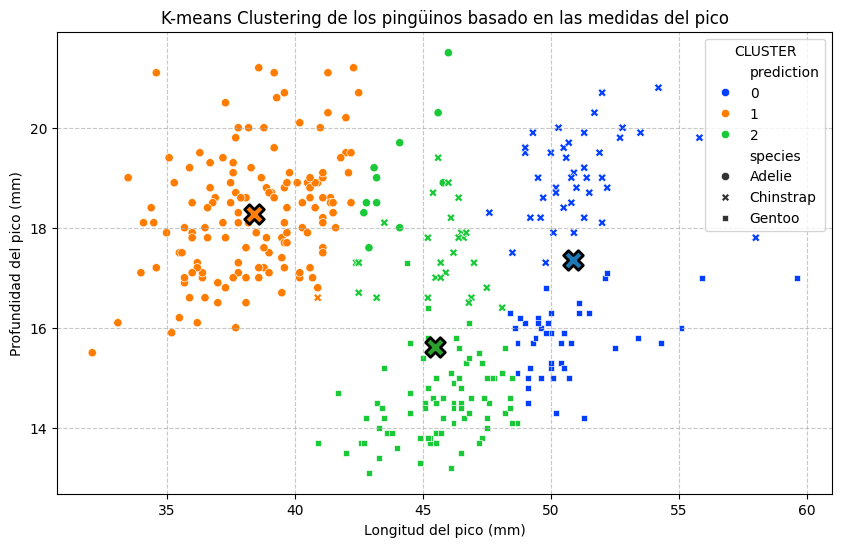

In [25]:
pandas_df = predictions.select("culmen_length_mm", "culmen_depth_mm", "prediction", "species").toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="culmen_length_mm",
    y="culmen_depth_mm",
    hue="prediction",
    style="species",
    palette="bright",
    data=pandas_df
)

for i, centroid in enumerate(centroids):
    plt.scatter(
        centroid[0],
        centroid[1],
        s=200,
        marker='X',
        c=f'C{i}',
        edgecolors='k',
        linewidth=2
    )

plt.title("K-means Clustering de los pingüinos basado en las medidas del pico")
plt.xlabel("Longitud del pico (mm)")
plt.ylabel("Profundidad del pico (mm)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="CLUSTER")

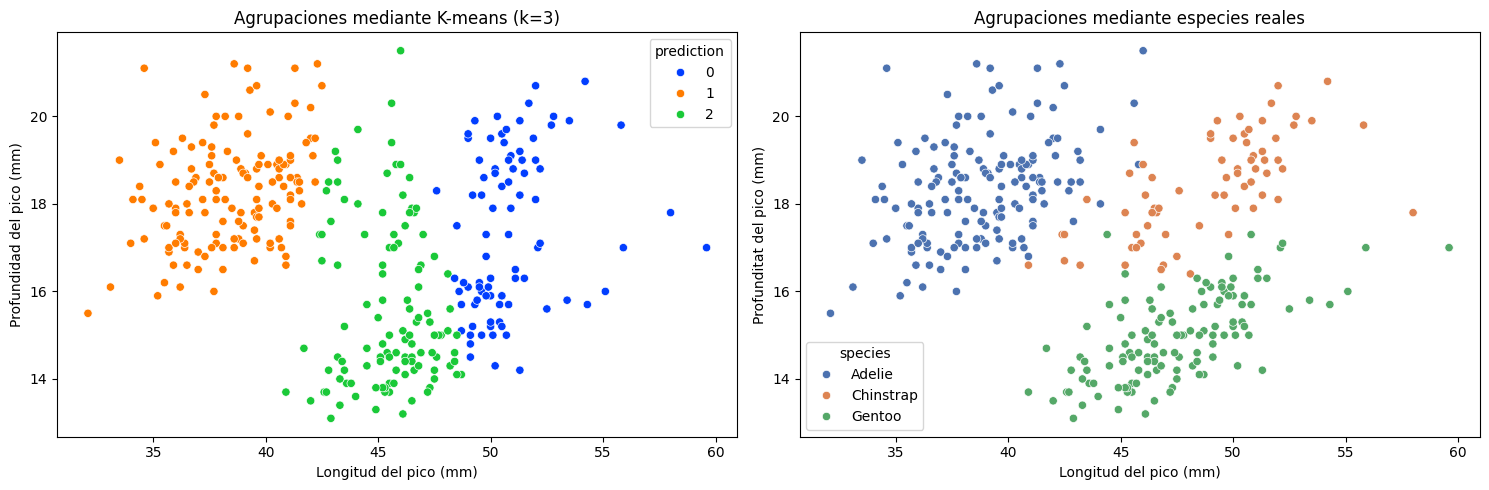


Relación entre clusters i especies:
species     Adelie  Chinstrap  Gentoo
prediction                           
0              0.0       41.0    45.0
1            140.0        1.0     0.0
2             11.0       26.0    78.0


In [36]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(
    x="culmen_length_mm",
    y="culmen_depth_mm",
    hue="prediction",
    palette="bright",
    data=pandas_df
)
plt.title("Agrupaciones mediante K-means (k=3)")
plt.xlabel("Longitud del pico (mm)")
plt.ylabel("Profundidad del pico (mm)")

plt.subplot(1, 2, 2)
sns.scatterplot(
    x="culmen_length_mm",
    y="culmen_depth_mm",
    hue="species",
    palette="deep",
    data=pandas_df
)
plt.title("Agrupaciones mediante especies reales")
plt.xlabel("Longitud del pico (mm)")
plt.ylabel("Profunditat del pico (mm)")

plt.tight_layout()
plt.show()

print("\nRelación entre clusters i especies:")
cluster_species = pandas_df.groupby(['prediction', 'species']).size().reset_index(name='count')
pivot_table = cluster_species.pivot(index='prediction', columns='species', values='count').fillna(0)
print(pivot_table)

In [37]:
def purity_score(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    import numpy as np
    if y_true.dtype == 'object':
        unique_labels = y_true.unique()
        label_mapping = {label: i for i, label in enumerate(unique_labels)}
        y_true = y_true.map(label_mapping)

    contingency_matrix = confusion_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=1)) / np.sum(contingency_matrix)

purity = purity_score(pandas_df['species'], pandas_df['prediction'])

print("\n###### RESUMEN DEL ANÁLISIS DE CLUSTERING ######")
print(f"\nNúmero de files analizadas: {penguins_clean.count()}")
print(f"Coeficiente Silhouette: {silhouette:.4f}")
print(f"Pureza del clustering: {purity:.4f}")


###### RESUMEN DEL ANÁLISIS DE CLUSTERING ######

Número de files analizadas: 344
Coeficiente Silhouette: 0.6711
Pureza del clustering: 0.7573


# Conclusiones

En este análisis hemos utilizado el algoritmo K-means con k=3 para agrupar los datos de pingüinos, trabajando únicamente con la longitud y la profundidad del pico como variables principales. A partir de los resultados obtenidos, podemos extraer las siguientes conclusiones:

1. **Coeficiente Silhouette**: Según el valor que obtenemos sabemos a qué nivel de bien o mal están diferenciados los clústers. Cuanto más cercano a 1 es el valor mejor es la separación, en nuestro caso 0.6711 no es un valor extremadamente cercano a 1 sin embargo sí que va en esa dirección, no está mal pero tampoco es el mejor de los resultados.

2. **Correspondencia con especies reales**: Los datos muestran que los clústers que agrupados por k-means tienen cierta similitud a los de las especies reales, esto es algo positivo porque nos da a entender que las dimensiones del pico son datos clave para diferenciar las especies de pingüinos en este caso.

3. **Centroides**: Cada centroide representa las medidas típicas del pico en su grupo y permite asignar nuevos pingüinos al clúster correcto usando solo esas dos dimensiones.

4. **Pureza de los clústers**: La pureza del clustering es de 0.7573, lo que indica que la mayoría de los pingüinos dentro de cada grupo pertenecen a la misma especie. Aunque no es perfecta, muestra que el modelo ha conseguido separar bastante bien las especies solo usando las medidas del pico.


En resumen, el clustering ha hecho un buen trabajo separando las especies de pingüinos basándose solo en la longitud y la profundidad del pico. Aunque el resultado no es perfecto, tanto el coeficiente Silhouette como la pureza indican que estas dos medidas son bastante útiles para distinguir los grupos. Se podría mejorar incluyendo más características, pero para ser solo con el pico, el resultado es bastante bueno.